In [1]:
'''
=====Experiment=====
'''
DATASET_NAME = "BoT_IoT"

GRAPH_CONSTRUCTION = 'host'
WINDOW_SIZE = 3500

MULTICLASS = True

LOAD_SAVED = False

FIRST_RUN = not LOAD_SAVED

from torch_geometric.utils import from_networkx, add_self_loops, degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch as th
import torch.nn.functional as F
# import dgl.function as fn
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np
import os
import sys
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch_geometric.loader import DataLoader
import joblib

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(project_root)

from Datasets.BoT_IoT.BoT_IoT_config import BoT_IoT_Config as Dataset_Config

EXPERIMENT_NAME = f"strat_window_{GRAPH_CONSTRUCTION}_{WINDOW_SIZE}"

SOURCE_IP_COL_NAME = Dataset_Config.SOURCE_IP_COL_NAME
DESTINATION_IP_COL_NAME = Dataset_Config.DESTINATION_IP_COL_NAME
SOURCE_PORT_COL_NAME = Dataset_Config.SOURCE_PORT_COL_NAME
DESTINATION_PORT_COL_NAME = Dataset_Config.DESTINATION_PORT_COL_NAME

ATTACK_CLASS_COL_NAME = Dataset_Config.ATTACK_CLASS_COL_NAME
IS_ATTACK_COL_NAME = Dataset_Config.IS_ATTACK_COL_NAME

BENIGN_CLASS_NAME = Dataset_Config.BENIGN_CLASS_NAME

TIME_COLS = Dataset_Config.TIME_COL_NAMES

DROP_COLS = Dataset_Config.DROP_COLS

COLS_TO_NORM = Dataset_Config.COLS_TO_NORM
CATEGORICAL_COLS = Dataset_Config.CATEGORICAL_COLS

if MULTICLASS:
    label_col = ATTACK_CLASS_COL_NAME
else:
    label_col = IS_ATTACK_COL_NAME

save_path = os.path.join(project_root, f"Models/E_GraphSAGE_edge/{DATASET_NAME}/saved", EXPERIMENT_NAME)

checkpoint_path = os.path.join(save_path, f"checkpoints.pth")
best_model_path = os.path.join(save_path, f"best_model.pth")

os.makedirs(save_path, exist_ok=True)


In [2]:
if FIRST_RUN:
    csv_file_name = "all_raw"

    data = pd.read_csv(os.path.join(project_root, "Datasets", f"{DATASET_NAME}/All/{csv_file_name}.csv"))

In [3]:
if FIRST_RUN:
    print(data[ATTACK_CLASS_COL_NAME].value_counts())
    print(data[IS_ATTACK_COL_NAME].value_counts())

    if MULTICLASS:
        data.drop(columns=[IS_ATTACK_COL_NAME], inplace=True)
    else:
        data.drop(columns=[ATTACK_CLASS_COL_NAME], inplace=True)

category
DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: count, dtype: int64
attack
1    3668045
0        477
Name: count, dtype: int64


In [4]:
if FIRST_RUN:
    data.drop(columns=DROP_COLS,inplace=True)
    print(data.columns)

Index(['pkSeqID', 'stime', 'flgs_number', 'proto_number', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state_number', 'ltime', 'dur',
       'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category'],
      dtype='object')


In [5]:
if FIRST_RUN:
    if GRAPH_CONSTRUCTION == 'endpoint':
        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME].apply(str)
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME].apply(str)

        # # Combine Port and IP
        data[SOURCE_PORT_COL_NAME] = data[SOURCE_PORT_COL_NAME].apply(str)
        data[DESTINATION_PORT_COL_NAME] = data[DESTINATION_PORT_COL_NAME].apply(str)

        data[SOURCE_IP_COL_NAME] = data[SOURCE_IP_COL_NAME] + ':' + data[SOURCE_PORT_COL_NAME]
        data[DESTINATION_IP_COL_NAME] = data[DESTINATION_IP_COL_NAME] + ':' + data[DESTINATION_PORT_COL_NAME]
        data.drop(columns=[SOURCE_PORT_COL_NAME,DESTINATION_PORT_COL_NAME],inplace=True)

        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]

    elif GRAPH_CONSTRUCTION == 'host':
        data = pd.get_dummies(data, columns = CATEGORICAL_COLS) # One Hot Encoding for categorical data
        converted_categorical_cols = [col for col in data.columns if col.startswith(tuple(CATEGORICAL_COLS))]
        COLS_TO_NORM = COLS_TO_NORM + [SOURCE_PORT_COL_NAME, DESTINATION_PORT_COL_NAME]
    else:
        raise ValueError("Invalid GRAPH_CONSTRUCTION value. Use 'host' or 'endpoint'.")
    

In [6]:
if FIRST_RUN:
    # Clean NaN values
    data.reset_index(drop=True, inplace=True)
    data.replace([np.inf, -np.inf], np.nan,inplace = True)
    data.fillna(0,inplace = True)

In [7]:
if not LOAD_SAVED:
    # Normalize numerical columns
    scaler = StandardScaler()
    print(data[COLS_TO_NORM].describe()) # Check if there's any too large value

    # Check for numeric issues in the columns before normalization
    def check_numeric_issues(df, cols_to_norm):
        for col in cols_to_norm:
            try:
                # Try to coerce to numeric
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
            except Exception as e:
                print(f"❌ Column '{col}' failed with error: {e}")
                print(f"  - Sample values: {df[col].dropna().unique()[:5]}")
                print(f"  - Data type: {df[col].dtype}")
                continue

        print("\n✅ All other columns processed successfully.")

    check_numeric_issues(data, COLS_TO_NORM)

    data[COLS_TO_NORM] = scaler.fit_transform(data[COLS_TO_NORM])

    # Save the scaler for future use
    scaler_path = os.path.join(save_path, "scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print("Data after normalization:")

               pkts         bytes           dur          mean        stddev  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.725963e+00  8.690501e+02  2.033479e+01  2.231063e+00  8.871499e-01   
std    1.155876e+02  1.122667e+05  2.148764e+01  1.517728e+00  8.037139e-01   
min    1.000000e+00  6.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.000000e+00  4.200000e+02  1.256256e+01  1.819670e-01  3.001900e-02   
50%    7.000000e+00  6.000000e+02  1.550852e+01  2.690125e+00  7.938960e-01   
75%    9.000000e+00  7.700000e+02  2.709986e+01  3.565203e+00  1.745296e+00   
max    7.005700e+04  7.183334e+07  2.771485e+03  4.981882e+00  2.496763e+00   

                sum           min           max         spkts         dpkts  \
count  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06  3.668522e+06   
mean   7.721635e+00  1.017540e+00  3.020015e+00  7.314146e+00  4.118173e-01   
std    7.616199e+00  1.483688e+00  1.860877e+00  7.

In [8]:
if LOAD_SAVED:
    # load scaler
    scaler_path = os.path.join(save_path, "scaler.pkl")
    scaler = joblib.load(scaler_path)

In [9]:
if FIRST_RUN:
    num_classes = 2
    class_map = [0, 1]
    if MULTICLASS:
        le = LabelEncoder()
        attack_labels = le.fit_transform(data[ATTACK_CLASS_COL_NAME])
        class_map = le.classes_
        print(class_map)
        print("Attack label mapping:", dict(zip(class_map, range(len(class_map)))))
        data[ATTACK_CLASS_COL_NAME] = attack_labels
        num_classes = len(class_map)
        class_dict = {le.inverse_transform([i])[0]: i for i in range(len(le.classes_))}

    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    joblib.dump(le, labeller_path)
    joblib.dump(class_map, class_map_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
Attack label mapping: {'DDoS': 0, 'DoS': 1, 'Normal': 2, 'Reconnaissance': 3, 'Theft': 4}


In [10]:
if LOAD_SAVED:
    # Save the class map BENIGN_CLASS_LABEL, ADVERSARIAL_CLASS_LABEL
    class_map_path = os.path.join(save_path, "class_map.pkl")
    labeller_path = os.path.join(save_path, "labeller.pkl")

    class_map = joblib.load(class_map_path)
    le = joblib.load(labeller_path)

    BENIGN_CLASS_LABEL = le.transform([BENIGN_CLASS_NAME])[0] if MULTICLASS else 0
    ADVERSARIAL_CLASS_LABEL = len(class_map)

In [11]:
if not LOAD_SAVED:
    # Maintain the order of the rows in the original dataframe
    feature_cols = COLS_TO_NORM + converted_categorical_cols

    print('Feature Columns:', feature_cols)
    num_features = len(feature_cols)
    print('Number of Features:', num_features)

    data['h'] = data[ feature_cols ].values.tolist()
    print(data.head(5))

Feature Columns: ['pkts', 'bytes', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP', 'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport', 'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP', 'sport', 'dport', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3', 'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7', 'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2', 'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6', 'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10', 'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_3', 'proto_number_4', 'proto_number_5']
Number of Features: 56


   pkSeqID         stime           saddr     sport           daddr     dport  \
0  3576925  1.526344e+09   192.168.100.3 -1.718820  192.168.100.55  2.314129   
1  3576926  1.526344e+09  192.168.100.46 -1.542217   192.168.100.5 -0.094107   
2  3576919  1.526344e+09  192.168.100.46 -1.718820   192.168.100.5 -0.094107   
3  3576920  1.526344e+09  192.168.100.46 -1.718820   192.168.100.5 -0.094107   
4  3576922  1.526344e+09   192.168.100.7 -1.703912   192.168.100.3  0.051893   

         pkts       bytes         ltime        dur  ...  state_number_8  \
0  514.287519  542.313009  1.526346e+09  77.503750  ...           False   
1  514.278867  526.543278  1.526346e+09  77.503750  ...           False   
2  257.106013  254.240221  1.526346e+09  77.503750  ...           False   
3  260.834786  257.403476  1.526346e+09  77.503750  ...           False   
4  141.176650    8.717557  1.526346e+09  77.516146  ...           False   

   state_number_9  state_number_10  state_number_11  proto_number_1 

In [12]:
def create_graph(df):

    G_nx = nx.from_pandas_edgelist(df, SOURCE_IP_COL_NAME, DESTINATION_IP_COL_NAME, ['h', label_col], create_using=nx.MultiDiGraph())
    
    G_pyg = from_networkx(G_nx)

    num_nodes = G_pyg.num_nodes
    num_edges = G_pyg.num_edges

    assert num_edges == G_nx.number_of_edges(), "Number of edges in PyG graph does not match NetworkX graph."

    G_pyg.x = th.ones(num_nodes, len(df['h'].iloc[0])) 

    edge_attr_list = []
    edge_label_list = []

    for u, v, key, data in G_nx.edges(keys=True, data=True):
        edge_attr_list.append(data['h']) 
        edge_label_list.append(data[label_col]) 

    G_pyg.edge_attr = th.tensor(edge_attr_list, dtype=th.float32)
    G_pyg.edge_label = th.tensor(edge_label_list, dtype=th.long)

    return G_pyg

In [13]:
from collections import defaultdict
from typing import Counter
from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

class StratifiedGraphDataset:

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.total_count = len(self.y)

        # Compute class weights
        labels = []

        for graph in self.X:
            labels.append(graph.edge_label.tolist())

        labels = np.concatenate(labels)

        self.class_counts = Counter(labels)

        # Compute the class weights
        self.class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(labels),
            y=labels
        )

    def k_fold_split(self, k: int = 5, test_ratio: float = 0.15, random_state: int = 42):
        cv = MultilabelStratifiedShuffleSplit(test_size=test_ratio, random_state=random_state, n_splits=k)

        mlb = MultiLabelBinarizer()

        y_binary = mlb.fit_transform(self.y)

        return cv.split(np.zeros(len(self.X)), y_binary)

    def graph_train_test_split(self, test_ratio: float = 0.15, random_state: int = 42):
        train_idx, test_idx = next(self.k_fold_split(k = 1, test_ratio = test_ratio, random_state = random_state))
        
        X_train = [self.X[i] for i in train_idx]
        X_test = [self.X[i] for i in test_idx]

        y_train = [self.y[i] for i in train_idx]
        y_test = [self.y[i] for i in test_idx]

        return StratifiedGraphDataset(X_train, y_train), StratifiedGraphDataset(X_test, y_test)
    
    def print_class_distribution_and_weights(self):
        # Use the label encoder to inverse transform the class labels
        class_counts_named = {cls: count for cls, count in self.class_counts.items()}
        class_weights_named = {cls: weight for cls, weight in enumerate(self.class_weights)}
        print("Class Counts and Weights:")
        for cls_label in class_counts_named.keys():
            count = class_counts_named[cls_label]
            weight = class_weights_named[cls_label]
            print(f"{cls_label:<2}  {le.inverse_transform([cls_label])[0]:<15}: Count = {count:<10}, Weight = {weight:<10.4f}")
    
    def __len__(self):
        return self.total_count

    def __iter__(self):
        for g in self.X:
            yield g
            
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.X[idx], self.y[idx]
        elif isinstance(idx, slice):
            return [self.X[i] for i in range(len(self.X))][idx], [self.y[i] for i in range(len(self.y))][idx]
        else:
            raise TypeError("Index must be an integer or a slice.")

In [14]:
if FIRST_RUN:
    def generate_graph_datasets(
        df: pd.DataFrame, 
        window_size: int = WINDOW_SIZE, 
        feature_cols=feature_cols,
        ordering_cols= TIME_COLS, 
        label_col=label_col,
        build_graph_func=create_graph,
        ):

        print("All Columns: ", df.columns)
        print("Ordering Columns: ", ordering_cols)
        assert all(col in df.columns for col in ordering_cols), "All timestamp columns are required"
        assert label_col in df.columns, "Edge label column 'label' is required"
        
        df = df.sort_values(ordering_cols).reset_index(drop=True)
        window_size = int(window_size)
        
        df.drop(columns=set(df.columns) - set(feature_cols) - set(label_col))

        print("Final Columns: ", df.columns)
        
        label_counts_list = []
        X = []
        y = []

        progress_bar = tqdm(range(0, len(df), window_size), desc=f"Generating graphs")
        for start in progress_bar:
            window_df = df[start: min(start + window_size, len(df))]
            contains_label = window_df[label_col].unique()

            G_pyg = build_graph_func(window_df)

            label_counts = window_df[label_col].value_counts()

            label_counts_list.append(label_counts)
            X.append(G_pyg)
            y.append(contains_label.tolist())

        return StratifiedGraphDataset(X, y)

In [15]:
test_graph_dataset_path = os.path.join(save_path, "test_graph_dataset.pth")
if FIRST_RUN:
    graph_dataset = generate_graph_datasets(data)
    full_train_graph_dataset, test_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)
    th.save(test_graph_dataset, test_graph_dataset_path)

if LOAD_SAVED:
    # Save or Load test_graph_dataset
    if os.path.exists(test_graph_dataset_path):  
        test_graph_dataset = th.load(test_graph_dataset_path, weights_only=False)
    else:       
        raise FileNotFoundError(f"File {test_graph_dataset_path} does not exist. Please run the code to generate the dataset first.")
    

All Columns:  Index(['pkSeqID', 'stime', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes',
       'ltime', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
       'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category', 'flgs_number_1', 'flgs_number_2', 'flgs_number_3',
       'flgs_number_4', 'flgs_number_5', 'flgs_number_6', 'flgs_number_7',
       'flgs_number_8', 'flgs_number_9', 'state_number_1', 'state_number_2',
       'state_number_3', 'state_number_4', 'state_number_5', 'state_number_6',
       'state_number_7', 'state_number_8', 'state_number_9', 'state_number_10',
       'state_number_11', 'proto_number_1', 'proto_number_2', 'proto_number_

Generating graphs: 100%|██████████| 1049/1049 [02:20<00:00,  7.46it/s]


In [16]:
if FIRST_RUN:
    print("Class Distrubution:", data[label_col].value_counts())

    print("Number of graphs after downsampling:", len(graph_dataset))
    graph_dataset.print_class_distribution_and_weights()

    print("Number of training graphs:", len(full_train_graph_dataset))
    full_train_graph_dataset.print_class_distribution_and_weights()

    print("Number of testing graphs:", len(test_graph_dataset))
    test_graph_dataset.print_class_distribution_and_weights()

Class Distrubution: category
0    1926624
1    1650260
3      91082
2        477
4         79
Name: count, dtype: int64
Number of graphs after downsampling: 1049
Class Counts and Weights:
2   Normal         : Count = 477       , Weight = 1538.1644 
3   Reconnaissance : Count = 91082     , Weight = 8.0554    
1   DoS            : Count = 1650260   , Weight = 0.4446    
0   DDoS           : Count = 1926624   , Weight = 0.3808    
4   Theft          : Count = 79        , Weight = 9287.3975 
Number of training graphs: 891
Class Counts and Weights:
2   Normal         : Count = 446       , Weight = 1397.0951 
3   Reconnaissance : Count = 77113     , Weight = 8.0804    
1   DoS            : Count = 1401760   , Weight = 0.4445    
0   DDoS           : Count = 1636124   , Weight = 0.3808    
4   Theft          : Count = 79        , Weight = 7887.3975 
Number of testing graphs: 158
Class Counts and Weights:
3   Reconnaissance : Count = 13969     , Weight = 9.8969    
2   Normal         : Count =

In [17]:
class SAGELayerPyG(MessagePassing):
    def __init__(self, in_channels, edge_dim, out_channels, activation=F.relu):
        super().__init__(aggr='mean')  # mean aggregation
        self.W_apply = nn.Linear(in_channels + edge_dim, out_channels)
        self.activation = activation

    def forward(self, x, edge_index, edge_attr):
        # x: [num_nodes, in_channels]
        # edge_attr: [num_edges, edge_dim]
        return self.propagate(edge_index, x=x, edge_attr=edge_attr, size=(x.size(0), x.size(0)))

    def message(self, edge_attr):
        return edge_attr

    def update(self, aggr_out, x):
        # aggr_out: [num_nodes, out_channels]
        combined = th.cat([x, aggr_out], dim=1)
        out = self.W_apply(combined)
        return self.activation(out)
    
class MLPPredictor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MLPPredictor, self).__init__()
        self.lin = nn.Linear(in_channels * 2, out_channels)

    def forward(self, data, z):
        row, col = data.edge_index
        # Concatenate the features of source and target nodes for each edge
        edge_feat = th.cat([z[row], z[col]], dim=1)
        return self.lin(edge_feat)

class EGraphSAGE(nn.Module):
    def __init__(self, node_in_channels, edge_in_channels, hidden_channels, out_channels, dropout=0.2):
        super(EGraphSAGE, self).__init__()
        self.dropout = dropout
        self.conv1 = SAGELayerPyG(node_in_channels, edge_in_channels, hidden_channels)
        self.conv2 = SAGELayerPyG(hidden_channels, edge_in_channels, hidden_channels)
        self.mlp_predictor = MLPPredictor(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return self.mlp_predictor(data, x)

In [18]:
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
th.cuda.empty_cache()

In [20]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

In [21]:
from sklearn.metrics import f1_score

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()


In [22]:
if FIRST_RUN:
    def grid_search(graph_dataset, patience, max_epochs, learning_rates, hidden_dims, drop_outs, folds=3):
        global num_features
        
        best_params = {}
        best_f1 = 0
        params_results = {}

        # Precompute the train and validation graphs for all folds
        folds_list = []
        for i in range(folds):
            train_graph_dataset, val_graph_dataset = graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=i)
            folds_list.append((train_graph_dataset, val_graph_dataset))

        for lr in learning_rates:
            for hidden_dim in hidden_dims:
                for drop_out in drop_outs:
                    print(f"Testing with learning rate: {lr}, hidden_dim: {hidden_dim}, drop_out: {drop_out}")
                    fold_f1_scores = []

                    for fold, (train_graph_dataset, val_graph_dataset) in enumerate(folds_list):
                        print(f"Fold {fold + 1}")

                        model = EGraphSAGE(node_in_channels=num_features,
                                        edge_in_channels=num_features,
                                        hidden_channels=hidden_dim,
                                        dropout = drop_out,
                                        out_channels=num_classes).to(device)

                        model.apply(init_weights)

                        # Normalize to stabilize training
                        class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
                        print("Class weights:", class_weights)

                        criterion = nn.CrossEntropyLoss(weight=class_weights)
                        optimizer = th.optim.Adam(model.parameters(), lr=lr)
                        scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
                            optimizer,
                            mode='min',
                            factor=0.6,
                            patience=5,
                            min_lr=1e-6,
                        )

                        best_epoch_f1 = 0  # Track the best F1 score for this fold
                        best_val_loss = float('inf')  # Track the best val_loss for this fold
                        patience_counter = 0

                        for epoch in range(max_epochs):
                            try:
                                train_loss = 0
                                val_loss = 0
                                num_train_graphs = len(train_graph_dataset)
                                num_val_graphs = len(val_graph_dataset)

                                model.train()
                                optimizer.zero_grad()
                                for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                                    G_pyg_train = G_pyg_train.to(device)
                                    G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                                    G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)
                                    
                                    out = model(G_pyg_train)
                                    loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                                    train_loss += loss.item()

                                    loss.backward()

                                optimizer.step()
                                

                                test_label_list = []
                                pred_label_list = []

                                model.eval()
                                with th.no_grad():
                                    for G_pyg_val in tqdm(val_graph_dataset, desc="Validation", leave=False):

                                        G_pyg_val = G_pyg_val.to(device)
                                        G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                                        G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                                        out = model(G_pyg_val)
                                        loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                                        val_loss += loss.item()

                                        test_label_list.append(G_pyg_val.edge_label.cpu())
                                        pred_label_list.append(out.argmax(dim=1).cpu())

                                test_label = th.cat(test_label_list)
                                pred_label = th.cat(pred_label_list)

                                val_f1 = f1_score(test_label, pred_label, average='weighted')
                                val_f1_micro = f1_score(test_label, pred_label, average='micro')
                                val_f1_macro = f1_score(test_label, pred_label, average='macro')

                                # Schedule step
                                scheduler.step(val_loss)

                                if val_f1 > best_epoch_f1:
                                    best_epoch_f1 = val_f1
                                    print(f"Epoch {epoch}/{max_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                                    f"Val F1 (weighted): {val_f1:.4f}, Micro: {val_f1_micro:.4f}, Macro: {val_f1_macro:.4f} "
                                    f"(Best Weighted F1 so far: {best_epoch_f1:.4f})")

                                # Early stopping condition
                                if val_loss < best_val_loss:
                                    best_val_loss = val_loss
                                    patience_counter = 0
                                else:
                                    patience_counter += 1

                                if patience_counter >= patience:
                                    print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
                                    break

                            except Exception as e:
                                print(f"An error occurred at epoch {epoch}: {str(e)}")
                                break

                        fold_f1_scores.append(best_epoch_f1)  # Append the best F1 score for this fold
                    
                    avg_f1 = sum(fold_f1_scores) / len(fold_f1_scores)
                    params_results[(drop_out, lr, hidden_dim)] = {'folds': fold_f1_scores, 'avg_f1': avg_f1}
                    print(f"Average F1 Score for drop_out {drop_out}, learning rate {lr}, hidden_dim {hidden_dim}: {avg_f1:.4f}")

                    if avg_f1 > best_f1:
                        best_f1 = avg_f1
                        best_params = {'learning_rate': lr, 'hidden_dim': hidden_dim, 'drop_out': drop_out}

        print(f"Best Parameters: {best_params}, Best F1 Score: {best_f1:.4f}")
        print("All results:", params_results)

    # grid_search(
    #     full_train_graph_dataset, 
    #     patience=10,
    #     max_epochs=200,
    #     learning_rates=[0.001, 0.005, 0.01, 0.05], 
    #     hidden_dims=[128, 256, 512], 
    #     drop_outs=[0.2, 0.3, 0.4],
    #     folds=3)


In [23]:
if FIRST_RUN:
    train_graph_dataset, val_graph_dataset = full_train_graph_dataset.graph_train_test_split(test_ratio=0.15, random_state=42)

In [24]:
def save_checkpoint():
    global epoch, model, optimizer, scheduler, train_loss_history, val_loss_history, val_f1_history, saved_model_epochs, best_f1, patience_counter, best_val_loss, train_ended, max_epochs, patience
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'val_f1_history': val_f1_history,
        'saved_model_epochs': saved_model_epochs,
        'best_f1': best_f1,
        # 'patience_counter': patience_counter,
        # 'best_val_loss': best_val_loss,
        'train_ended': train_ended,
        'max_epochs': max_epochs,
        # 'patience': patience
    }
    
    th.save(checkpoint, checkpoint_path)

In [25]:
# Best parameters from the grid search
best_hidden_dim = 256  # Replace with the best hidden_dim found
best_learning_rate = 0.01  # Replace with the best learning_rate found
best_drop_out = 0.3  # Replace with the best drop_out found
if FIRST_RUN:

    max_epochs = 200
    # patience = 10

    print("Number of train graphs: ", len(train_graph_dataset))

    # Initialize the model with the best parameters
    model = EGraphSAGE(node_in_channels=num_features, 
                    edge_in_channels=num_features,
                    hidden_channels=best_hidden_dim,
                    dropout = best_drop_out,
                    out_channels=num_classes).to(device)

    model.apply(init_weights)

    # Normalize class weights
    class_weights = th.FloatTensor(train_graph_dataset.class_weights).to(device)
    print("Class weights:", class_weights)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = th.optim.Adam(model.parameters(), lr=best_learning_rate)
    scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.6,
        patience=5,
        min_lr=1e-6,
    )

    # ===== Load checkpoint if exists =====
    start_epoch = 0
    best_f1 = 0

    # patience_counter = 0
    best_val_loss = float('inf')
    train_ended = False

    train_loss_history = []
    val_loss_history = []
    val_f1_history = []
    saved_model_epochs = []

    if os.path.exists(checkpoint_path):
        checkpoint = th.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        train_ended = checkpoint['train_ended']
        best_f1 = checkpoint['best_f1']

        assert max_epochs == checkpoint['max_epochs'], "Checkpoint max_epochs does not match the current setting."
        # assert patience == checkpoint['patience'], "Checkpoint patience does not match the current setting."

        # patience_counter = checkpoint['patience_counter']
        # best_val_loss = checkpoint['best_val_loss']

        start_epoch = checkpoint['epoch'] + 1

        train_loss_history = checkpoint['train_loss_history']
        val_loss_history = checkpoint['val_loss_history']
        val_f1_history = checkpoint['val_f1_history']
        saved_model_epochs = checkpoint['saved_model_epochs']
        print(f"Resumed training from epoch {start_epoch}")

    if train_ended:
        model.load_state_dict(th.load(best_model_path))
        print("Training has already ended. Loaded the best model state.")
        print("Training history loaded successfully.")

    else:
        # ===== Start Training =====
        num_train_graphs = len(train_graph_dataset)
        num_val_graphs = len(val_graph_dataset)

        for epoch in range(start_epoch, max_epochs):

            model.train()

            train_loss = 0
            val_loss = 0

            optimizer.zero_grad()
            for G_pyg_train in tqdm(train_graph_dataset, desc="Training", leave=False):

                # Move the graph data to the device
                G_pyg_train = G_pyg_train.to(device)
                G_pyg_train.edge_label = G_pyg_train.edge_label.to(device)
                G_pyg_train.edge_attr = G_pyg_train.edge_attr.to(device)

                out = model(G_pyg_train)
                loss = criterion(out, G_pyg_train.edge_label) / num_train_graphs
                
                train_loss += loss.item()
                loss.backward()

            optimizer.step()
            
            test_label_list = []
            pred_label_list = []

            model.eval()
            with th.no_grad():
                for G_pyg_val in tqdm(val_graph_dataset, desc="Evaluation", leave=False):
                    G_pyg_val = G_pyg_val.to(device)
                    G_pyg_val.edge_label = G_pyg_val.edge_label.to(device)
                    G_pyg_val.edge_attr = G_pyg_val.edge_attr.to(device)

                    out = model(G_pyg_val)
                    loss = criterion(out, G_pyg_val.edge_label) / num_val_graphs
                    val_loss += loss.item()

                    test_label_list.append(G_pyg_val.edge_label.cpu())
                    pred_label_list.append(out.argmax(dim=1).cpu())

            test_label = th.cat(test_label_list)
            pred_label = th.cat(pred_label_list)

            val_f1 = f1_score(test_label, pred_label, average='weighted')
            val_f1_micro = f1_score(test_label, pred_label, average='micro')
            val_f1_macro = f1_score(test_label, pred_label, average='macro')

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)
            val_f1_history.append((val_f1, val_f1_micro, val_f1_macro))

            # Schedule step
            scheduler.step(val_loss)

            if val_f1 > best_f1:
                best_f1 = val_f1  # Update the best F1 score for this fold
                best_model_state = model.state_dict()
                saved_model_epochs.append(epoch)

                save_checkpoint()
                th.save(best_model_state, best_model_path)
                print(f"Epoch {epoch} Saved best model. Best F1:", best_f1)

            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}, Validation F1 Micro: {val_f1_micro:.4f}, Validation F1 Macro: {val_f1_macro:.4f}')
            
            if epoch % 10 == 0:
                save_checkpoint()

            # # Early stopping condition
            # if val_loss < best_val_loss:
            #     best_val_loss = val_loss
            #     patience_counter = 0
            # else:
            #     patience_counter += 1

            # if patience_counter >= patience:
            #     print(f"\n🛑 Early stopping triggered at epoch {epoch}.")
            #     train_ended = True
            #     break

        # Save the trained model
        train_ended = True
        save_checkpoint()
        print("Model training completed and saved.")

Number of train graphs:  757
Class weights: tensor([3.8145e-01, 4.4414e-01, 1.2367e+03, 7.9438e+00, 6.7001e+03],
       device='cuda:0')


Training:  17%|█▋        | 125/757 [00:01<00:03, 165.04it/s]

Epoch 0 Saved best model. Best F1: 0.367090197320016
Epoch 0, Train Loss: 1.8278, Validation Loss: 1.0148, Validation F1: 0.3671, Validation F1 Micro: 0.5299, Validation F1 Macro: 0.4232


Epoch 1, Train Loss: 1.0647, Validation Loss: 6.1954, Validation F1: 0.2770, Validation F1 Micro: 0.4478, Validation F1 Macro: 0.4046


Epoch 2, Train Loss: 6.0740, Validation Loss: 2.0674, Validation F1: 0.2827, Validation F1 Micro: 0.4507, Validation F1 Macro: 0.4619


Epoch 3 Saved best model. Best F1: 0.37961454267910405
Epoch 3, Train Loss: 2.0070, Validation Loss: 0.8694, Validation F1: 0.3796, Validation F1 Micro: 0.5352, Validation F1 Macro: 0.5548


Epoch 4 Saved best model. Best F1: 0.3817641855134612
Epoch 4, Train Loss: 0.8773, Validation Loss: 1.0834, Validation F1: 0.3818, Validation F1 Micro: 0.5374, Validation F1 Macro: 0.5575


Epoch 5 Saved best model. Best F1: 0.39603298573895795
Epoch 5, Train Loss: 1.1140, Validation Loss: 0.8187, Validation F1: 0.3960, Validation F1 Micro: 0.5423, Validation F1 Macro: 0.5462


Epoch 6 Saved best model. Best F1: 0.6974916114340428
Epoch 6, Train Loss: 0.8668, Validation Loss: 0.7111, Validation F1: 0.6975, Validation F1 Micro: 0.7233, Validation F1 Macro: 0.7267


Epoch 7 Saved best model. Best F1: 0.8401489962779046
Epoch 7, Train Loss: 0.7351, Validation Loss: 0.6316, Validation F1: 0.8401, Validation F1 Micro: 0.8430, Validation F1 Macro: 0.8029


Epoch 8 Saved best model. Best F1: 0.8593693447298986
Epoch 8, Train Loss: 0.6375, Validation Loss: 0.5415, Validation F1: 0.8594, Validation F1 Micro: 0.8615, Validation F1 Macro: 0.8231


Epoch 9 Saved best model. Best F1: 0.8727514677610517
Epoch 9, Train Loss: 0.5371, Validation Loss: 0.4811, Validation F1: 0.8728, Validation F1 Micro: 0.8760, Validation F1 Macro: 0.8169


Epoch 10, Train Loss: 0.4845, Validation Loss: 0.4488, Validation F1: 0.8646, Validation F1 Micro: 0.8713, Validation F1 Macro: 0.7474


Epoch 11 Saved best model. Best F1: 0.883178567014373
Epoch 11, Train Loss: 0.4423, Validation Loss: 0.4253, Validation F1: 0.8832, Validation F1 Micro: 0.8898, Validation F1 Macro: 0.7565


Epoch 12 Saved best model. Best F1: 0.8907352093346137
Epoch 12, Train Loss: 0.4305, Validation Loss: 0.4013, Validation F1: 0.8907, Validation F1 Micro: 0.8975, Validation F1 Macro: 0.7596


Epoch 13 Saved best model. Best F1: 0.9000277137610933
Epoch 13, Train Loss: 0.3924, Validation Loss: 0.3727, Validation F1: 0.9000, Validation F1 Micro: 0.9067, Validation F1 Macro: 0.7649


Epoch 14 Saved best model. Best F1: 0.9004836320971404
Epoch 14, Train Loss: 0.3566, Validation Loss: 0.3393, Validation F1: 0.9005, Validation F1 Micro: 0.9071, Validation F1 Macro: 0.7656


Epoch 15 Saved best model. Best F1: 0.9007370680871696
Epoch 15, Train Loss: 0.3188, Validation Loss: 0.3005, Validation F1: 0.9007, Validation F1 Micro: 0.9074, Validation F1 Macro: 0.7661


Epoch 16 Saved best model. Best F1: 0.9092804976394303
Epoch 16, Train Loss: 0.2878, Validation Loss: 0.2601, Validation F1: 0.9093, Validation F1 Micro: 0.9160, Validation F1 Macro: 0.7708


Epoch 17 Saved best model. Best F1: 0.9322932877622157
Epoch 17, Train Loss: 0.2584, Validation Loss: 0.2219, Validation F1: 0.9323, Validation F1 Micro: 0.9341, Validation F1 Macro: 0.8775


Epoch 18 Saved best model. Best F1: 0.9475590161233854
Epoch 18, Train Loss: 0.2216, Validation Loss: 0.1903, Validation F1: 0.9476, Validation F1 Micro: 0.9495, Validation F1 Macro: 0.8786


Epoch 19 Saved best model. Best F1: 0.9594863052679816
Epoch 19, Train Loss: 0.2006, Validation Loss: 0.1618, Validation F1: 0.9595, Validation F1 Micro: 0.9614, Validation F1 Macro: 0.8848


Epoch 20 Saved best model. Best F1: 0.961401762866731
Epoch 20, Train Loss: 0.1779, Validation Loss: 0.1368, Validation F1: 0.9614, Validation F1 Micro: 0.9633, Validation F1 Macro: 0.8877


Epoch 21 Saved best model. Best F1: 0.9699587798062932
Epoch 21, Train Loss: 0.1555, Validation Loss: 0.1186, Validation F1: 0.9700, Validation F1 Micro: 0.9716, Validation F1 Macro: 0.8807


Epoch 22 Saved best model. Best F1: 0.9748635050396929
Epoch 22, Train Loss: 0.1395, Validation Loss: 0.1036, Validation F1: 0.9749, Validation F1 Micro: 0.9759, Validation F1 Macro: 0.9025


Epoch 23 Saved best model. Best F1: 0.9786665249149799
Epoch 23, Train Loss: 0.1239, Validation Loss: 0.0886, Validation F1: 0.9787, Validation F1 Micro: 0.9797, Validation F1 Macro: 0.9044


Epoch 24, Train Loss: 0.1152, Validation Loss: 0.0768, Validation F1: 0.9787, Validation F1 Micro: 0.9797, Validation F1 Macro: 0.9044


Epoch 25, Train Loss: 0.0998, Validation Loss: 0.0651, Validation F1: 0.9787, Validation F1 Micro: 0.9797, Validation F1 Macro: 0.9044


Epoch 26, Train Loss: 0.0855, Validation Loss: 0.0555, Validation F1: 0.9786, Validation F1 Micro: 0.9797, Validation F1 Macro: 0.9043


Epoch 27 Saved best model. Best F1: 0.9831876633279985
Epoch 27, Train Loss: 0.0779, Validation Loss: 0.0473, Validation F1: 0.9832, Validation F1 Micro: 0.9850, Validation F1 Macro: 0.8868


Epoch 28 Saved best model. Best F1: 0.9856135652554313
Epoch 28, Train Loss: 0.0657, Validation Loss: 0.0403, Validation F1: 0.9856, Validation F1 Micro: 0.9877, Validation F1 Macro: 0.8995


Epoch 29, Train Loss: 0.0602, Validation Loss: 0.0358, Validation F1: 0.9846, Validation F1 Micro: 0.9870, Validation F1 Macro: 0.8921


Epoch 30, Train Loss: 0.0579, Validation Loss: 0.0343, Validation F1: 0.9846, Validation F1 Micro: 0.9870, Validation F1 Macro: 0.8857


Epoch 31, Train Loss: 0.0488, Validation Loss: 0.0306, Validation F1: 0.9856, Validation F1 Micro: 0.9877, Validation F1 Macro: 0.8870


Epoch 32 Saved best model. Best F1: 0.9972537650658331
Epoch 32, Train Loss: 0.0455, Validation Loss: 0.0272, Validation F1: 0.9973, Validation F1 Micro: 0.9973, Validation F1 Macro: 0.9669


Epoch 33, Train Loss: 0.0438, Validation Loss: 0.0223, Validation F1: 0.9973, Validation F1 Micro: 0.9973, Validation F1 Macro: 0.9669


Epoch 34 Saved best model. Best F1: 0.9994928054970748
Epoch 34, Train Loss: 0.0363, Validation Loss: 0.0179, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.9804


Epoch 35, Train Loss: 0.0322, Validation Loss: 0.0161, Validation F1: 0.9973, Validation F1 Micro: 0.9973, Validation F1 Macro: 0.9669


Epoch 36, Train Loss: 0.0315, Validation Loss: 0.0143, Validation F1: 0.9973, Validation F1 Micro: 0.9973, Validation F1 Macro: 0.9669


Epoch 37, Train Loss: 0.0258, Validation Loss: 0.0125, Validation F1: 0.9973, Validation F1 Micro: 0.9973, Validation F1 Macro: 0.7784


Epoch 38 Saved best model. Best F1: 0.9994963597763507
Epoch 38, Train Loss: 0.0281, Validation Loss: 0.0114, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7529


Epoch 39, Train Loss: 0.0252, Validation Loss: 0.0104, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7529


Epoch 40, Train Loss: 0.0222, Validation Loss: 0.0097, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7529


Epoch 41, Train Loss: 0.0223, Validation Loss: 0.0091, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7529


Epoch 42, Train Loss: 0.0166, Validation Loss: 0.0087, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7529


Epoch 43, Train Loss: 0.0174, Validation Loss: 0.0082, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7529


Epoch 44, Train Loss: 0.0183, Validation Loss: 0.0074, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7529


Epoch 45 Saved best model. Best F1: 0.9994972898289971
Epoch 45, Train Loss: 0.0172, Validation Loss: 0.0067, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.7466


Epoch 46, Train Loss: 0.0132, Validation Loss: 0.0065, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.9296


Epoch 47 Saved best model. Best F1: 0.9995009920049752
Epoch 47, Train Loss: 0.0134, Validation Loss: 0.0064, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.9296


Epoch 48, Train Loss: 0.0137, Validation Loss: 0.0062, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.9296


Epoch 49, Train Loss: 0.0110, Validation Loss: 0.0058, Validation F1: 0.9995, Validation F1 Micro: 0.9995, Validation F1 Macro: 0.9296


Epoch 50 Saved best model. Best F1: 0.9997547092626811
Epoch 50, Train Loss: 0.0105, Validation Loss: 0.0055, Validation F1: 0.9998, Validation F1 Micro: 0.9998, Validation F1 Macro: 0.9298


Epoch 51, Train Loss: 0.0100, Validation Loss: 0.0057, Validation F1: 0.9998, Validation F1 Micro: 0.9998, Validation F1 Macro: 0.9298


Epoch 52, Train Loss: 0.0110, Validation Loss: 0.0059, Validation F1: 0.9975, Validation F1 Micro: 0.9976, Validation F1 Macro: 0.9163


Epoch 53, Train Loss: 0.0089, Validation Loss: 0.0063, Validation F1: 0.9975, Validation F1 Micro: 0.9976, Validation F1 Macro: 0.9163


Epoch 54, Train Loss: 0.0087, Validation Loss: 0.0070, Validation F1: 0.9975, Validation F1 Micro: 0.9976, Validation F1 Macro: 0.9163


Epoch 55, Train Loss: 0.0083, Validation Loss: 0.0075, Validation F1: 0.9968, Validation F1 Micro: 0.9969, Validation F1 Macro: 0.9118


Epoch 56, Train Loss: 0.0080, Validation Loss: 0.0076, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 57, Train Loss: 0.0087, Validation Loss: 0.0077, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 58, Train Loss: 0.0103, Validation Loss: 0.0072, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 59, Train Loss: 0.0110, Validation Loss: 0.0066, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 60, Train Loss: 0.0078, Validation Loss: 0.0061, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 61, Train Loss: 0.0113, Validation Loss: 0.0059, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 62, Train Loss: 0.0075, Validation Loss: 0.0058, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 63, Train Loss: 0.0062, Validation Loss: 0.0058, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 64, Train Loss: 0.0065, Validation Loss: 0.0061, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 65, Train Loss: 0.0069, Validation Loss: 0.0061, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 66, Train Loss: 0.0087, Validation Loss: 0.0061, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 67, Train Loss: 0.0071, Validation Loss: 0.0061, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 68, Train Loss: 0.0064, Validation Loss: 0.0060, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 69, Train Loss: 0.0078, Validation Loss: 0.0060, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 70, Train Loss: 0.0064, Validation Loss: 0.0059, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 71, Train Loss: 0.0073, Validation Loss: 0.0058, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 72, Train Loss: 0.0077, Validation Loss: 0.0053, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 73, Train Loss: 0.0061, Validation Loss: 0.0050, Validation F1: 0.9970, Validation F1 Micro: 0.9971, Validation F1 Macro: 0.9119


Epoch 74, Train Loss: 0.0065, Validation Loss: 0.0048, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 75, Train Loss: 0.0064, Validation Loss: 0.0047, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 76, Train Loss: 0.0087, Validation Loss: 0.0046, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 77, Train Loss: 0.0055, Validation Loss: 0.0046, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 78, Train Loss: 0.0063, Validation Loss: 0.0046, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 79, Train Loss: 0.0084, Validation Loss: 0.0045, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 80, Train Loss: 0.0066, Validation Loss: 0.0045, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 81, Train Loss: 0.0059, Validation Loss: 0.0046, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 82, Train Loss: 0.0054, Validation Loss: 0.0047, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 83, Train Loss: 0.0060, Validation Loss: 0.0046, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 84, Train Loss: 0.0074, Validation Loss: 0.0046, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 85, Train Loss: 0.0064, Validation Loss: 0.0045, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 86, Train Loss: 0.0064, Validation Loss: 0.0044, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 87, Train Loss: 0.0053, Validation Loss: 0.0043, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 88, Train Loss: 0.0058, Validation Loss: 0.0043, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 89, Train Loss: 0.0074, Validation Loss: 0.0041, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 90, Train Loss: 0.0054, Validation Loss: 0.0040, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 91, Train Loss: 0.0055, Validation Loss: 0.0040, Validation F1: 0.9977, Validation F1 Micro: 0.9978, Validation F1 Macro: 0.9164


Epoch 92, Train Loss: 0.0068, Validation Loss: 0.0040, Validation F1: 0.9975, Validation F1 Micro: 0.9975, Validation F1 Macro: 0.9162


Epoch 93, Train Loss: 0.0055, Validation Loss: 0.0039, Validation F1: 0.9975, Validation F1 Micro: 0.9975, Validation F1 Macro: 0.9162


Epoch 94, Train Loss: 0.0060, Validation Loss: 0.0038, Validation F1: 0.9975, Validation F1 Micro: 0.9975, Validation F1 Macro: 0.9162


Epoch 95, Train Loss: 0.0052, Validation Loss: 0.0039, Validation F1: 0.9975, Validation F1 Micro: 0.9975, Validation F1 Macro: 0.9162


Epoch 96, Train Loss: 0.0050, Validation Loss: 0.0039, Validation F1: 0.9975, Validation F1 Micro: 0.9975, Validation F1 Macro: 0.9162


Epoch 97, Train Loss: 0.0054, Validation Loss: 0.0040, Validation F1: 0.9975, Validation F1 Micro: 0.9975, Validation F1 Macro: 0.9162


Epoch 98, Train Loss: 0.0053, Validation Loss: 0.0043, Validation F1: 0.9975, Validation F1 Micro: 0.9975, Validation F1 Macro: 0.9162


Epoch 99, Train Loss: 0.0050, Validation Loss: 0.0045, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 100, Train Loss: 0.0065, Validation Loss: 0.0047, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 101, Train Loss: 0.0061, Validation Loss: 0.0047, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 102, Train Loss: 0.0052, Validation Loss: 0.0047, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 103, Train Loss: 0.0051, Validation Loss: 0.0046, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 104, Train Loss: 0.0049, Validation Loss: 0.0045, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 105, Train Loss: 0.0062, Validation Loss: 0.0045, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 106, Train Loss: 0.0065, Validation Loss: 0.0044, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 107, Train Loss: 0.0053, Validation Loss: 0.0044, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 108, Train Loss: 0.0059, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 109, Train Loss: 0.0049, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 110, Train Loss: 0.0064, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 111, Train Loss: 0.0047, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 112, Train Loss: 0.0051, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 113, Train Loss: 0.0051, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 114, Train Loss: 0.0042, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 115, Train Loss: 0.0054, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 116, Train Loss: 0.0069, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 117, Train Loss: 0.0050, Validation Loss: 0.0043, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 118, Train Loss: 0.0052, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 119, Train Loss: 0.0051, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 120, Train Loss: 0.0044, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 121, Train Loss: 0.0048, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 122, Train Loss: 0.0051, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 123, Train Loss: 0.0059, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 124, Train Loss: 0.0054, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 125, Train Loss: 0.0056, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 126, Train Loss: 0.0051, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 127, Train Loss: 0.0044, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 128, Train Loss: 0.0049, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 129, Train Loss: 0.0045, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 130, Train Loss: 0.0045, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 131, Train Loss: 0.0056, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 132, Train Loss: 0.0048, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 133, Train Loss: 0.0042, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 134, Train Loss: 0.0042, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 135, Train Loss: 0.0050, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 136, Train Loss: 0.0043, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 137, Train Loss: 0.0045, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 138, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 139, Train Loss: 0.0058, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 140, Train Loss: 0.0069, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 141, Train Loss: 0.0042, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 142, Train Loss: 0.0047, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 143, Train Loss: 0.0044, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 144, Train Loss: 0.0061, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 145, Train Loss: 0.0050, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 146, Train Loss: 0.0057, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 147, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 148, Train Loss: 0.0043, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 149, Train Loss: 0.0045, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 150, Train Loss: 0.0052, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 151, Train Loss: 0.0062, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 152, Train Loss: 0.0064, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 153, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 154, Train Loss: 0.0047, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 155, Train Loss: 0.0043, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 156, Train Loss: 0.0050, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 157, Train Loss: 0.0044, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 158, Train Loss: 0.0045, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 159, Train Loss: 0.0042, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 160, Train Loss: 0.0057, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 161, Train Loss: 0.0045, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 162, Train Loss: 0.0048, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 163, Train Loss: 0.0047, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 164, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 165, Train Loss: 0.0044, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 166, Train Loss: 0.0048, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 167, Train Loss: 0.0057, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 168, Train Loss: 0.0067, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 169, Train Loss: 0.0049, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 170, Train Loss: 0.0049, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 171, Train Loss: 0.0051, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 172, Train Loss: 0.0055, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 173, Train Loss: 0.0059, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 174, Train Loss: 0.0054, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 175, Train Loss: 0.0062, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 176, Train Loss: 0.0053, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 177, Train Loss: 0.0053, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 178, Train Loss: 0.0055, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 179, Train Loss: 0.0048, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 180, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 181, Train Loss: 0.0047, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 182, Train Loss: 0.0044, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 183, Train Loss: 0.0043, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 184, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 185, Train Loss: 0.0055, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 186, Train Loss: 0.0047, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 187, Train Loss: 0.0065, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 188, Train Loss: 0.0057, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 189, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 190, Train Loss: 0.0060, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 191, Train Loss: 0.0045, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 192, Train Loss: 0.0048, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 193, Train Loss: 0.0050, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 194, Train Loss: 0.0046, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 195, Train Loss: 0.0071, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 196, Train Loss: 0.0047, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 197, Train Loss: 0.0044, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 198, Train Loss: 0.0053, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117


Epoch 199, Train Loss: 0.0058, Validation Loss: 0.0042, Validation F1: 0.9967, Validation F1 Micro: 0.9968, Validation F1 Macro: 0.9117
Model training completed and saved.


In [26]:
def plot_training_process():
    checkpoint = th.load(checkpoint_path)

    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    val_f1_history = checkpoint['val_f1_history']
    saved_model_epochs = checkpoint['saved_model_epochs']

    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Train Loss
    axs[0].plot(train_loss_history, label='Train Loss', color='blue')
    axs[0].plot(val_loss_history, label='Validation Loss', color='red')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()
    axs[0].grid()

    val_f1_weighted_history = []
    val_f1_micro_history = []
    val_f1_macro_history = []

    for val_f1_weighted, val_f1_micro, val_f1_macro in val_f1_history:
        val_f1_weighted_history.append(val_f1_weighted)
        val_f1_micro_history.append(val_f1_micro)
        val_f1_macro_history.append(val_f1_macro)
    
    # Plot Validation F1

    axs[1].plot(val_f1_weighted_history, label='Validation F1 Weighted', color='green')
    axs[1].plot(val_f1_micro_history, label='Validation F1 Micro', color='blue')
    axs[1].plot(val_f1_macro_history, label='Validation F1 Macro', color='red')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Validation F1')
    axs[1].set_title('Validation F1 Score')
    axs[1].legend()
    axs[1].grid()

    # Add scatter for saved model epochs (e.g., F1 weighted here)
    axs[1].scatter(saved_model_epochs, [val_f1_weighted_history[i] for i in saved_model_epochs],
                   color='black', marker='o', label='Saved Model')
    axs[1].legend()

    print(len(train_loss_history))

    plt.tight_layout()
    plt.show()

200


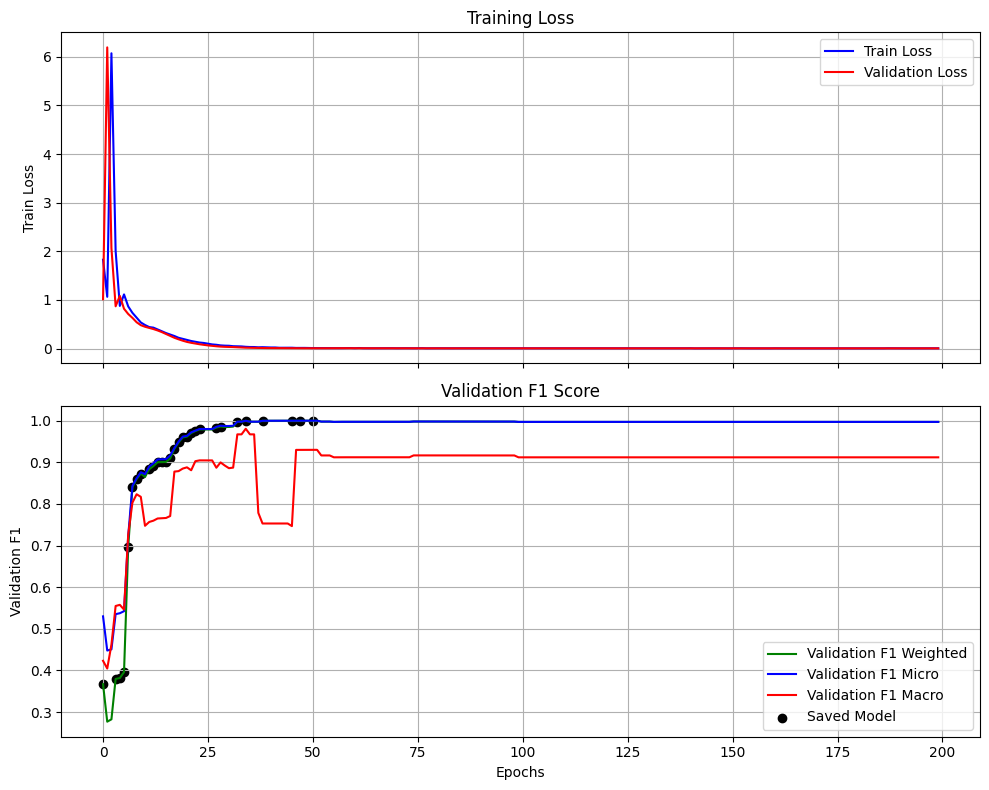

In [27]:
plot_training_process()

In [28]:
import torch
from torch_geometric.utils import degree
from collections import defaultdict

def check_global_avg_degrees_per_class(graph_dataset):
    # Dictionaries to hold total degree sums and counts per class
    total_out_deg = defaultdict(float)
    total_in_deg = defaultdict(float)
    count_out_nodes = defaultdict(int)
    count_in_nodes = defaultdict(int)
    min_out_deg = defaultdict(lambda: float('inf'))
    max_out_deg = defaultdict(lambda: float('-inf'))
    min_in_deg = defaultdict(lambda: float('inf'))
    max_in_deg = defaultdict(lambda: float('-inf'))

    for graph in graph_dataset:
        edge_index = graph.edge_index
        edge_label = graph.edge_label
        num_nodes = graph.num_nodes

        unique_classes = torch.unique(edge_label)

        for cls in unique_classes:
            cls = int(cls)
            mask = (edge_label == cls)

            src_nodes = edge_index[0][mask]
            dst_nodes = edge_index[1][mask]

            out_deg = degree(src_nodes, num_nodes=num_nodes)
            in_deg = degree(dst_nodes, num_nodes=num_nodes)

            involved_src = out_deg > 0
            involved_dst = in_deg > 0

            total_out_deg[cls] += out_deg[involved_src].sum().item()
            total_in_deg[cls] += in_deg[involved_dst].sum().item()
            count_out_nodes[cls] += involved_src.sum().item()
            count_in_nodes[cls] += involved_dst.sum().item()

            if involved_src.any():
                min_out_deg[cls] = min(min_out_deg[cls], out_deg[involved_src].min().item())
                max_out_deg[cls] = max(max_out_deg[cls], out_deg[involved_src].max().item())
            if involved_dst.any():
                min_in_deg[cls] = min(min_in_deg[cls], in_deg[involved_dst].min().item())
                max_in_deg[cls] = max(max_in_deg[cls], in_deg[involved_dst].max().item())

    print("Average, Min, and Max Degrees Across All Graphs:")
    class_degree_report = {}
    for cls in sorted(total_out_deg.keys()):
        avg_out = total_out_deg[cls] / count_out_nodes[cls] if count_out_nodes[cls] > 0 else 0.0
        avg_in = total_in_deg[cls] / count_in_nodes[cls] if count_in_nodes[cls] > 0 else 0.0
        min_out = min_out_deg[cls] if min_out_deg[cls] != float('inf') else 0.0
        max_out = max_out_deg[cls] if max_out_deg[cls] != float('-inf') else 0.0
        min_in = min_in_deg[cls] if min_in_deg[cls] != float('inf') else 0.0
        max_in = max_in_deg[cls] if max_in_deg[cls] != float('-inf') else 0.0

        epsilon = 1e-6 # to avoid division by zero
        avg_influence = (avg_out ** 2) / ((avg_in + epsilon) * WINDOW_SIZE)
        max_influence = (max_out ** 2) / ((min_in + epsilon) * WINDOW_SIZE)
        min_influence = (min_out ** 2) / ((max_in + epsilon) * WINDOW_SIZE)

        print(f"  Attack Class {le.inverse_transform([cls])}:")
        print(f"    Avg Out-Degree (src): {avg_out:.4f} | Min: {min_out:.0f} | Max: {max_out:.0f}")
        print(f"    Avg In-Degree (dst): {avg_in:.4f} | Min: {min_in:.0f} | Max: {max_in:.0f}")
        print(f"    Influence: {avg_influence:.4f} | Min: {min_influence:.4f} | Max: {max_influence:.4f}")

        class_degree_report[le.inverse_transform([cls])[0]] = {
            "avg_out": avg_out,
            "min_out": min_out,
            "max_out": max_out,
            "avg_in": avg_in,
            "min_in": min_in,
            "max_in": max_in,
            "avg_influence": avg_influence,
            "min_influence": min_influence,
            "max_influence": max_influence
        }

    return class_degree_report

class_degree_report = check_global_avg_degrees_per_class(test_graph_dataset)

Average, Min, and Max Degrees Across All Graphs:
  Attack Class ['DDoS']:
    Avg Out-Degree (src): 919.3038 | Min: 1 | Max: 3500
    Avg In-Degree (dst): 3057.8947 | Min: 1 | Max: 3500
    Influence: 0.0790 | Min: 0.0000 | Max: 3499.9965
  Attack Class ['DoS']:
    Avg Out-Degree (src): 997.9920 | Min: 1 | Max: 3500
    Avg In-Degree (dst): 997.9920 | Min: 1 | Max: 3500
    Influence: 0.2851 | Min: 0.0000 | Max: 3499.9965
  Attack Class ['Normal']:
    Avg Out-Degree (src): 2.2143 | Min: 1 | Max: 10
    Avg In-Degree (dst): 1.7222 | Min: 1 | Max: 4
    Influence: 0.0008 | Min: 0.0001 | Max: 0.0286
  Attack Class ['Reconnaissance']:
    Avg Out-Degree (src): 665.1905 | Min: 1 | Max: 1393
    Avg In-Degree (dst): 735.2105 | Min: 1 | Max: 3485
    Influence: 0.1720 | Min: 0.0000 | Max: 554.4134


In [29]:
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

def eval(dataset, adversarial=False):

    # Check if dataset is a list of (data, label) tuples or just data objects
    if isinstance(dataset[0], (list, tuple)):
        data_obj = dataset[0][0]
    else:
        data_obj = dataset[0]

    num_features = data_obj.edge_attr.shape[1]
    best_model = EGraphSAGE(node_in_channels=num_features, 
                       edge_in_channels=num_features,
                       hidden_channels=best_hidden_dim, 
                       out_channels=len(class_map)).to(device)

    print("Loading model from", best_model_path)
    best_model.load_state_dict(th.load(best_model_path))

    best_model.eval()

    print("inference start")
    with th.no_grad():
        all_pred_logits = []
        all_test_labels = []
        for G_pyg in tqdm(dataset, desc="Evaluation", leave=False):
            try:
                # Move the graph data to the device
                G_pyg = G_pyg.to(device)
                G_pyg.edge_label = G_pyg.edge_label.to(device)
                G_pyg.edge_attr = G_pyg.edge_attr.to(device)
                out = best_model(G_pyg)
                
            except Exception as forward_error:
                print(f"Error during forward/backward pass at {forward_error}")

            all_pred_logits.append(out.cpu())
            all_test_labels.append(G_pyg.edge_label.cpu())

        all_pred_logits = th.cat(all_pred_logits).to(device)
        all_test_labels = th.cat(all_test_labels).to(device)
        test_accuracy = compute_accuracy(all_pred_logits, all_test_labels)
        print(f'Test Accuracy: {test_accuracy:.4f}')

        pred_labels = all_pred_logits.argmax(dim=1).cpu()
        all_test_labels = all_test_labels.cpu()
    
    if adversarial:

        # Create a boolean mask where the label is NOT equal to the adversarial class
        adversarial_mask = all_test_labels == ADVERSARIAL_CLASS_LABEL

        # Print the class that the adversarial samples are classified as
        cm_adversarial = confusion_matrix(all_test_labels[adversarial_mask], pred_labels[adversarial_mask], labels=range(len(class_map) + 1))
        print("Adversarial confusion matrix:", cm_adversarial)

        # Apply the mask to both labels and predictions
        all_test_labels = all_test_labels[~adversarial_mask]
        pred_labels = pred_labels[~adversarial_mask]

    print("class_map", class_map)
    # Generate a report
    cm = confusion_matrix(all_test_labels, pred_labels, labels=range(len(class_map)))
    print(cm)

    report = classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, labels=range(len(class_map)))
    print(report)
    
    return classification_report(all_test_labels, pred_labels, target_names=class_map, digits=4, output_dict=True, labels=range(len(class_map)))


print("Number of test graphs: ", len(test_graph_dataset))
normal_report = eval(test_graph_dataset)


Number of test graphs:  158
Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.9793
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[282573   7926      0      1      0]
 [  3500 244992      7      1      0]
 [     0      0     31      0      0]
 [     0      0      4  13965      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9878    0.9727    0.9802    290500
           DoS     0.9687    0.9859    0.9772    248500
        Normal     0.7381    1.0000    0.8493        31
Reconnaissance     0.9999    0.9997    0.9998     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9793    553000
     macro avg     0.7389    0.7917    0.7613    553000
  weighted avg     0.9795    0.9793    0.9793    553000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [30]:
def inject_traffic_to_node(graph, ratio=0.1, num_injected_nodes=1, to_node_type='both', random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_edges = edge_index.size(1)
    feature_dim = graph.x.size(1)

    # Get all src nodes
    if to_node_type == 'src':
         to_nodes = edge_index[0]

    elif to_node_type == 'dst':
         to_nodes = edge_index[1]

    elif to_node_type == 'both':
         to_nodes = th.cat([edge_index[0], edge_index[1]])

    else:
        raise ValueError("to_node_type must be 'src', 'dst', or 'both'.")

    original_num_nodes = x.size(0)

    new_node_feats = th.ones((num_injected_nodes, feature_dim))
    x = th.cat([x, new_node_feats], dim=0)

    # 4. Inject edges from injected nodes to attacker nodes
    num_to_inject = max(1, int(ratio * num_edges))
    new_edges = []
    new_attrs = []
    new_labels = []
    
    for i in range(num_to_inject):
        rng = random.Random(random_seed + i)  # ensure different seed per iteration
        src = rng.randint(original_num_nodes, original_num_nodes + num_injected_nodes - 1)  # from injected nodes
        dst = rng.choice(to_nodes.tolist())  # to existing nodes

        new_edges.append([src, dst])
        attr = th.rand(feature_dim)  # random feature for the new edge
        new_attrs.append(attr)
        new_labels.append(ADVERSARIAL_CLASS_LABEL)

    # Create a new empty graph to store the injected edges
    new_graph = Data()

    # 5. Merge into graph
    if new_edges:
        new_edges = th.tensor(new_edges, dtype=th.long).t().contiguous()
        new_attrs = th.stack(new_attrs)
        new_labels = th.tensor(new_labels, dtype=th.long)

        new_graph.edge_index = th.cat([edge_index, new_edges], dim=1)
        new_graph.edge_attr = th.cat([edge_attr, new_attrs], dim=0)
        new_graph.edge_label = th.cat([edge_label, new_labels], dim=0)
        new_graph.x = x

    return new_graph



In [31]:
# Inject Attack Traffic to Attacker Nodes
inject_both_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='both') for g in test_graph_dataset]
inject_both_report = eval(inject_both_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8812
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [14400 12555     1 28344     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[283075   7421      0      4      0]
 [  3500 238932   6059      9      0]
 [     0      0     31      0      0]
 [     0      0      3  13966      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9878    0.9744    0.9811    290500
           DoS     0.9699    0.9615    0.9657    248500
        Normal     0.0051    1.0000    0.0101        31
Reconnaissance     0.9991    0.9998    0.9994     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9693    553000
     macro avg     0.5924    0.7871    0.5913    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [32]:
# Inject Attack Traffic to Attacker Nodes
inject_src_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='src') for g in test_graph_dataset]
inject_src_report = eval(inject_src_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8862
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [  180   175     0 54945     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[283075   7421      0      4      0]
 [  3500 241974   3017      9      0]
 [     0      0     31      0      0]
 [     0      0      1  13968      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9878    0.9744    0.9811    290500
           DoS     0.9702    0.9737    0.9720    248500
        Normal     0.0102    1.0000    0.0201        31
Reconnaissance     0.9991    0.9999    0.9995     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9748    553000
     macro avg     0.5935    0.7896    0.5945    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [33]:
# Inject Attack Traffic to Attacker Nodes
inject_dst_graph_dataset = [inject_traffic_to_node(g.cpu(), 0.1, num_injected_nodes=1, to_node_type='dst') for g in test_graph_dataset]
inject_dst_report = eval(inject_dst_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8960
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [28282 25618     4  1396     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[282539   7960      0      1      0]
 [     0 248491      8      1      0]
 [     0      0     31      0      0]
 [     0      0      4  13965      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     1.0000    0.9726    0.9861    290500
           DoS     0.9690    1.0000    0.9842    248500
        Normal     0.7209    1.0000    0.8378        31
Reconnaissance     0.9999    0.9997    0.9998     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9856    553000
     macro avg     0.7379    0.7945    0.7616    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [34]:
# Edge Attribute Perturbation
def perturb_edge_attributes(graph, affected_edge_ratio=0.1, perturbation_ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()

    num_edges = edge_index.size(1)
    feature_dim = edge_attr.size(1)

    # Randomly select edges to perturb
    num_to_perturb = max(1, int(affected_edge_ratio * num_edges))
    rng = random.Random(random_seed)
    indices_to_perturb = rng.sample(range(num_edges), num_to_perturb)

    for idx in indices_to_perturb:
        # Perturb the edge attributes by adding noise
        noise = th.randn(feature_dim) * perturbation_ratio  # Adjust the scale of noise as needed
        edge_attr[idx] += noise

    # Create a new graph with perturbed attributes
    perturbed_graph = Data(edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label, x=graph.x)

    return perturbed_graph

In [35]:
# Edge Attribute Perturbation
edge_perturb_graph_dataset = [perturb_edge_attributes(g.cpu(), affected_edge_ratio=1, perturbation_ratio=5) for g in test_graph_dataset]
edge_perturb_report = eval(edge_perturb_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.9630
Adversarial confusion matrix: [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[282305   8161      0     34      0]
 [ 11342 236254      4    900      0]
 [     1      0     30      0      0]
 [     1      0      0  13968      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9614    0.9718    0.9666    290500
           DoS     0.9666    0.9507    0.9586    248500
        Normal     0.8824    0.9677    0.9231        31
Reconnaissance     0.9373    0.9999    0.9676     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9630    553000
     macro avg     0.7495    0.7780    0.7632    553000
  weighted avg     0.9631    0.9630    0.9630    553000



/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [36]:
# Inject Random Edges
def inject_random_edges(graph, ratio=0.1, random_seed=42):
    edge_index = graph.edge_index.clone()
    edge_attr = graph.edge_attr.clone()
    edge_label = graph.edge_label.clone()
    x = graph.x.clone()

    num_nodes = x.size(0)
    feature_dim = graph.x.size(1)

    new_edge_indices = []
    new_edge_attrs = []
    new_edge_labels = []

    num_edges = edge_index.size(1)
    num_injected_edges = max(1, int(ratio * num_edges))

    for i in range(num_injected_edges):
        rng = random.Random(random_seed + i)  # ensure different seed per edge
        src = rng.randint(0, num_nodes - 1)  # Random source node
        dst = rng.randint(0, num_nodes - 1)  # Random destination node

        new_edge_indices.append([src, dst])
        new_edge_attrs.append(th.rand(feature_dim))  # Random feature for the new edge
        new_edge_labels.append(ADVERSARIAL_CLASS_LABEL)

    if new_edge_indices:
        new_edge_indices = th.tensor(new_edge_indices, dtype=th.long).t().contiguous()
        new_edge_attrs = th.stack(new_edge_attrs)
        new_edge_labels = th.tensor(new_edge_labels, dtype=th.long)

        edge_index = th.cat([edge_index, new_edge_indices], dim=1)
        edge_attr = th.cat([edge_attr, new_edge_attrs], dim=0)
        edge_label = th.cat([edge_label, new_edge_labels], dim=0)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_label=edge_label)

In [37]:
# Inject Random Edges
random_edge_graph_dataset = [inject_random_edges(g.cpu(), 0.1) for g in test_graph_dataset]
random_edge_report = eval(random_edge_graph_dataset, adversarial=True)

Loading model from /vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/Models/E_GraphSAGE_edge/BoT_IoT/saved/strat_window_host_3500/best_model.pth
inference start


Evaluation:   0%|          | 0/158 [00:00<?, ?it/s]

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

Test Accuracy: 0.8810
Adversarial confusion matrix: [[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [ 6471 12261 24901 11667     0     0]]
class_map ['DDoS' 'DoS' 'Normal' 'Reconnaissance' 'Theft']
[[283230   7266      0      4      0]
 [  3500 238653   6338      9      0]
 [     0      0     31      0      0]
 [     0      0      1  13968      0]
 [     0      0      0      0      0]]
                precision    recall  f1-score   support

          DDoS     0.9878    0.9750    0.9813    290500
           DoS     0.9705    0.9604    0.9654    248500
        Normal     0.0049    1.0000    0.0097        31
Reconnaissance     0.9991    0.9999    0.9995     13969
         Theft     0.0000    0.0000    0.0000         0

      accuracy                         0.9690    553000
     macro avg     0.5924    0.7871    0.5912    553000
  weighted av

/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/vol/bitbucket/shc20/FYP/GNN-Adversarial-Attack/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this beha

In [38]:
def compare_overall_metrics(baseline_report, adversarial_reports, class_degree_report):
    rows = []   
    metrics = ['precision', 'recall', 'f1-score']
    eplison = 1e-10  # To avoid division by zero

    for label in list(class_map) + ['macro avg', 'weighted avg']:
        row = {"Class": label}
        row['Class'] = label
        row['Min Influence'] = class_degree_report[label]['min_influence'] if label in class_degree_report else 0.0
        row['Avg Influence'] = class_degree_report[label]['avg_influence'] if label in class_degree_report else 0.0
        row['Max Influence'] = class_degree_report[label]['max_influence'] if label in class_degree_report else 0.0
        for metric in metrics:
            baseline_val = baseline_report[label][metric]
            row[f"Normal {metric}"] = baseline_val
            for name, report in adversarial_reports.items():
                adv_val = report[label][metric]
                row[f"{name} {metric}"] = adv_val
                row[f"{name} {metric} Drop (%)"] = ((baseline_val - adv_val) / (baseline_val + eplison)) * 100
        row['support'] = int(baseline_report[label]['support'])
        rows.append(row)

    return pd.DataFrame(rows)

adversarial_reports = {
    "To Both": inject_both_report,
    "To Src": inject_src_report,
    "To Dst": inject_dst_report,
    "Edge Perturbation": edge_perturb_report,
    "Random Edge": random_edge_report,
}

comparison_df = compare_overall_metrics(normal_report, adversarial_reports, class_degree_report)

class_col = comparison_df['Class']
support_df = comparison_df['support']
normal_cols = [col for col in comparison_df.columns if col.startswith('Normal')] 
influence_cols = [col for col in comparison_df.columns if col.endswith('Influence')] 
influence_df = comparison_df[influence_cols]
f1_cols = [col for col in comparison_df.columns if col.endswith('f1-score')]
f1_drop_cols = [col for col in comparison_df.columns if col.endswith('f1-score Drop (%)')]

baselines_df = pd.concat([class_col, support_df, influence_df], axis=1)

f1_df = pd.concat([baselines_df, comparison_df[f1_cols]], axis=1)
f1_drop_df = pd.concat([baselines_df, comparison_df[f1_drop_cols]], axis=1)

print("Comparison of Overall Metrics:")
display(comparison_df.style.set_caption("Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))


Comparison of Overall Metrics:


,Class,Min Influence,Avg Influence,Max Influence,Normal precision,To Both precision,To Both precision Drop (%),To Src precision,To Src precision Drop (%),To Dst precision,To Dst precision Drop (%),Edge Perturbation precision,Edge Perturbation precision Drop (%),Random Edge precision,Random Edge precision Drop (%),Normal recall,To Both recall,To Both recall Drop (%),To Src recall,To Src recall Drop (%),To Dst recall,To Dst recall Drop (%),Edge Perturbation recall,Edge Perturbation recall Drop (%),Random Edge recall,Random Edge recall Drop (%),Normal f1-score,To Both f1-score,To Both f1-score Drop (%),To Src f1-score,To Src f1-score Drop (%),To Dst f1-score,To Dst f1-score Drop (%),Edge Perturbation f1-score,Edge Perturbation f1-score Drop (%),Random Edge f1-score,Random Edge f1-score Drop (%),support
0,DDoS,0.00,0.08,3500.00,0.99,0.99,-0.00,0.99,-0.00,1.00,-1.24,0.96,2.67,0.99,-0.00,0.97,0.97,-0.18,0.97,-0.18,0.97,0.01,0.97,0.09,0.97,-0.23,0.98,0.98,-0.09,0.98,-0.09,0.99,-0.60,0.97,1.39,0.98,-0.12,290500
1,DoS,0.00,0.29,3500.00,0.97,0.97,-0.13,0.97,-0.16,0.97,-0.03,0.97,0.21,0.97,-0.18,0.99,0.96,2.47,0.97,1.23,1.00,-1.43,0.95,3.57,0.96,2.59,0.98,0.97,1.18,0.97,0.53,0.98,-0.72,0.96,1.90,0.97,1.21,248500
2,Normal,0.00,0.00,0.03,0.74,0.01,99.31,0.01,98.62,0.72,2.33,0.88,-19.54,0.00,99.34,1.00,1.00,0.00,1.00,0.00,1.00,0.00,0.97,3.23,1.00,0.00,0.85,0.01,98.81,0.02,97.63,0.84,1.35,0.92,-8.68,0.01,98.86,31
3,Reconnaissance,0.00,0.17,554.41,1.00,1.00,0.08,1.00,0.08,1.00,0.00,0.94,6.25,1.00,0.08,1.00,1.00,-0.01,1.00,-0.02,1.00,0.00,1.00,-0.02,1.00,-0.02,1.00,1.00,0.04,1.00,0.03,1.00,0.00,0.97,3.22,1.00,0.03,13969
4,Theft,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0
5,macro avg,0.00,0.00,0.00,0.74,0.59,19.83,0.59,19.68,0.74,0.13,0.75,-1.44,0.59,19.82,0.79,0.79,0.57,0.79,0.26,0.79,-0.35,0.78,1.72,0.79,0.58,0.76,0.59,22.34,0.59,21.90,0.76,-0.04,0.76,-0.25,0.59,22.35,553000
6,weighted avg,0.00,0.00,0.00,0.98,0.98,-0.05,0.98,-0.07,0.99,-0.67,0.96,1.67,0.98,-0.08,0.98,0.97,1.03,0.97,0.46,0.99,-0.64,0.96,1.66,0.97,1.05,0.98,0.97,0.49,0.98,0.20,0.99,-0.64,0.96,1.67,0.97,0.49,553000


In [39]:
# Check F1 Scores
display(f1_df.style.background_gradient(cmap='Greens', subset=f1_cols, axis=0).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,Normal f1-score,To Both f1-score,To Src f1-score,To Dst f1-score,Edge Perturbation f1-score,Random Edge f1-score
0,DDoS,290500,0.00,0.08,3500.00,0.98,0.98,0.98,0.99,0.97,0.98
1,DoS,248500,0.00,0.29,3500.00,0.98,0.97,0.97,0.98,0.96,0.97
2,Normal,31,0.00,0.00,0.03,0.85,0.01,0.02,0.84,0.92,0.01
3,Reconnaissance,13969,0.00,0.17,554.41,1.00,1.00,1.00,1.00,0.97,1.00
4,Theft,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,macro avg,553000,0.00,0.00,0.00,0.76,0.59,0.59,0.76,0.76,0.59
6,weighted avg,553000,0.00,0.00,0.00,0.98,0.97,0.98,0.99,0.96,0.97


In [40]:
# Compare Drops per Adversarial Attack
display(f1_drop_df[f1_drop_df['Class'] == 'weighted avg'].style.background_gradient(cmap='Reds', subset=f1_drop_cols, axis=None).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
6,weighted avg,553000,0.00,0.00,0.00,0.49,0.20,-0.64,1.67,0.49


In [41]:
# Compare Drops per Class
display(f1_drop_df.style.background_gradient(cmap='Reds', subset=f1_drop_cols).set_caption("Percentage Drop in Metrics Under Adversarial Attacks").format({col: "{:.2f}" for col in comparison_df.columns if col not in ['Class', 'support']}))

,Class,support,Min Influence,Avg Influence,Max Influence,To Both f1-score Drop (%),To Src f1-score Drop (%),To Dst f1-score Drop (%),Edge Perturbation f1-score Drop (%),Random Edge f1-score Drop (%)
0,DDoS,290500,0.00,0.08,3500.00,-0.09,-0.09,-0.60,1.39,-0.12
1,DoS,248500,0.00,0.29,3500.00,1.18,0.53,-0.72,1.90,1.21
2,Normal,31,0.00,0.00,0.03,98.81,97.63,1.35,-8.68,98.86
3,Reconnaissance,13969,0.00,0.17,554.41,0.04,0.03,0.00,3.22,0.03
4,Theft,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,macro avg,553000,0.00,0.00,0.00,22.34,21.90,-0.04,-0.25,22.35
6,weighted avg,553000,0.00,0.00,0.00,0.49,0.20,-0.64,1.67,0.49


In [42]:
from collections import defaultdict
from pprint import pformat

def round_tuple(t):
    return tuple(round(x, 2) for x in t)

def print_results(class_degree_report, comparison_df):
    report_dict = defaultdict(dict)

    for class_name, metrics in class_degree_report.items():
        report_dict[class_name] = {
            "influence": round_tuple((metrics['min_influence'], metrics['avg_influence'], metrics['max_influence'])),
            "out_degree": round_tuple((metrics['min_out'], metrics['avg_out'], metrics['max_out'])),
            "in_degree": round_tuple((metrics['min_in'], metrics['avg_in'], metrics['max_in']))
        }

    for _, row in comparison_df.iterrows():
        class_name = row['Class']
        if class_name == 'weighted avg':
            class_name = 'Weighted Average'
        report_dict[class_name].update({
            "normal_f1": round(row['Normal f1-score'], 2),
            "to_both_f1": round(row['To Both f1-score'], 2),
            "to_src_f1": round(row['To Src f1-score'], 2),
            "to_dst_f1": round(row['To Dst f1-score'], 2),
            "edge_perturb_f1": round(row['Edge Perturbation f1-score'], 2),
            "random_edge_f1": round(row['Random Edge f1-score'], 2),
        })

    print(pformat(dict(report_dict), sort_dicts=False, indent=1))

print_results(class_degree_report, comparison_df)

{'DDoS': {'influence': (0.0, 0.08, 3500.0),
          'out_degree': (1.0, 919.3, 3500.0),
          'in_degree': (1.0, 3057.89, 3500.0),
          'normal_f1': 0.98,
          'to_both_f1': 0.98,
          'to_src_f1': 0.98,
          'to_dst_f1': 0.99,
          'edge_perturb_f1': 0.97,
          'random_edge_f1': 0.98},
 'DoS': {'influence': (0.0, 0.29, 3500.0),
         'out_degree': (1.0, 997.99, 3500.0),
         'in_degree': (1.0, 997.99, 3500.0),
         'normal_f1': 0.98,
         'to_both_f1': 0.97,
         'to_src_f1': 0.97,
         'to_dst_f1': 0.98,
         'edge_perturb_f1': 0.96,
         'random_edge_f1': 0.97},
 'Normal': {'influence': (0.0, 0.0, 0.03),
            'out_degree': (1.0, 2.21, 10.0),
            'in_degree': (1.0, 1.72, 4.0),
            'normal_f1': 0.85,
            'to_both_f1': 0.01,
            'to_src_f1': 0.02,
            'to_dst_f1': 0.84,
            'edge_perturb_f1': 0.92,
            'random_edge_f1': 0.01},
 'Reconnaissance': {'influence'